## Let's sum up all the analysis in a single dataframe !

In [1]:

import sys,os
import pickle

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly as pltly
import plotly.express as px
import plotly.graph_objects as go

from jax import vmap
import jax.numpy as jnp

# + local functions : 
from database_handling.database_extract import get_all_subject_data_from_internal_task_id
from utils import remove_by_indices
from analysis_tools.preprocess import get_preprocessed_data_from_df

def get_results_df(_internal_task_id,_studies_list = None,_exclude_subjects_list = [],
                   _llm_classification_code = None, _llm_classification_file_path = None,
                   _bins_fb_noise = None,
                   _override = False,
                   last_k_trials= 3,last_t_timesteps=5):
    
    if _studies_list is not None :
        # Get a list of the task results, 
        _tasks_results_all = []
        for prolific_study_id in _studies_list:
            task_results = get_all_subject_data_from_internal_task_id(_internal_task_id,prolific_study_id,
                                                                    process_feedback_data_stream=True,override_save=_override)
            print(" - Loaded the task results for study {} \n    ({} subjects.)".format(prolific_study_id,len(task_results)))
            _tasks_results_all += task_results
    else :
        _tasks_results_all = get_all_subject_data_from_internal_task_id(_internal_task_id,
                                                                        process_feedback_data_stream=True,override_save=_override)
        
    print("Total : {} subjects".format(len(_tasks_results_all)))



    # Each subject in task results has the following entries : 
    # TASK_RESULT_FEATURES, TASK_RESULTS_EVENTS, TASK_RESULTS_DATA, TASK_RESULTS,RT_FB
    
    # let's remove some subjects based on broad inclusion criteria : 
    # did not do the task twice, did not revoke the consent midpoint, etc.
    remove_these_subjects = []
    for index,entry in enumerate(_tasks_results_all):
        subj_dict,_,_,_ = entry
        subj_name = subj_dict["subject_id"]
        if subj_name in _exclude_subjects_list:
            remove_these_subjects.append(index)

    _tasks_results_all = remove_by_indices(_tasks_results_all,remove_these_subjects)
    print(str(len(_tasks_results_all)) + " subjects remaining after removing problematic subjects.")
    
    
    
    # Fill a dataframe with that data :
    
    
    
    # The initial datframe is the first tuple in our task result list of tuples : 
    subjects_df = pd.DataFrame([entry[0] for entry in _tasks_results_all])

    # Avoid too many categories : 
    subjects_df['Sex'] = np.where(subjects_df['Sex'].isin(['Male','Female']), subjects_df['Sex'], 'Other')

    category_counts = subjects_df['Nationality'].value_counts()
    threshold = 2
    subjects_df['Nationality_red'] = subjects_df['Nationality'].apply(lambda x: x if category_counts[x] >= threshold else 'Other')

    # There was a single noise term for the whole training for each subject : 
    subject_noise_parameters = [np.array(entry[2]["parameters"]["noise_int"])[0] for entry in _tasks_results_all]

    # We add it to the df : 
    subjects_df["feedback_noise_std"] = subject_noise_parameters

    # Time taken to solve the task 
    # Add the time taken recorded by the application : (a better measure than the one provided by Prolific for some reason)
    subjects_df["application_measured_timetaken"] = (subjects_df["finish_date"]-subjects_df["start_date"]).dt.total_seconds()

    
    
    
    
    
    
    
    
    
    # In this dataframe, we're interested in sorting various kinds of data from the trials : 
    # 1/ Data from the instruction phase
    # Load LLM classifications for text responses if they are available !
    if _llm_classification_code is not None :
        classification_instructions = {}
        try : 
            with open(_llm_classification_file_path, 'rb') as f:
                loaded_dict = pickle.load(f)
                
            for question_code,question_contents in loaded_dict.items():
                
                subject_classifs = question_contents["results"][_llm_classification_code]    

                
                subjects_df[question_code] = subject_classifs
                classification_instructions[question_code] = question_contents["prompt"]
                # print(subject_classifs)
            
        except : 
            print("Failed to load LLM classifications.")
    

    # 2/ Data from the feedback gauge :
    # Timestep values :
    all_subject_scores = [subjdata[2]["scoring"] for subjdata in _tasks_results_all]
    subjects_df["raw_feedback_values"] = [subj_scores["feedback"] for subj_scores in all_subject_scores]
    # Real time gauge values :
    subjects_df["realtime_values"] = [subjdata[3][1] for subjdata in _tasks_results_all] # Each element is a list of list os arrays (with varying shape)

    # 3/ Data from the hidden grid :
    # The grid for a specific trial: 
    trial_grids = [entry[2]["process"]["grids"] for entry in _tasks_results_all]
    subjects_df["grid_layout"] = trial_grids
    # Position value :
    subject_positions = [entry[2]["process"]["positions"] for entry in _tasks_results_all]
    subjects_df["subject_positions"] = subject_positions

    goal_positions = [np.array(entry[2]["parameters"]["goal_pos"])[:,0,:] for entry in _tasks_results_all]
    subjects_df["goal_position"] = goal_positions

    def euclidian_distance(position,goal):
        return jnp.linalg.norm(position-goal,2)
    gs = trial_grids[0][0].shape
    maximum_euclidian_dist = euclidian_distance(jnp.array(gs) - jnp.ones((2,)),jnp.zeros((2,)))
    all_euclidian_distances = vmap(vmap(vmap(euclidian_distance,in_axes=(0,None))))(jnp.array(subject_positions),jnp.array(goal_positions))/maximum_euclidian_dist
    subjects_df["norm_distance_to_goal"] = list(all_euclidian_distances)


    # 4/ Data from the realized actions :

    # Actions performed : this encompasses the points dropped
    # But may also include temporal elements such as :
    # - the time taken to perform an actions (first point / second point)
    # - when the action was performed with regard to the gauge
    canvas_size = _tasks_results_all[0][0]["canvas_size"] # Constant across all subjects + conditions
    all_actions_data = np.stack([subjdata[2]["blanket"]["actions"] for subjdata in _tasks_results_all]).astype(float)

    Nsubj,Ntrials,Nactions,Npoints,Nfeatures = all_actions_data.shape
    # print(all_actions_data)
    # Normalize the point data :
    all_actions_data[...,0] = all_actions_data[...,0]/canvas_size[0]
    all_actions_data[...,1] = 1.0 - all_actions_data[...,1]/canvas_size[1]


    # First, let's get a mask for all actions that were NOT performed :
    mask = all_actions_data[...,-1]==1  # values are 1 if the point was recorded
    both_points_only = (mask[...,0] & mask[...,1])
        # All points where at least one value is missing

    Nactions = all_actions_data[...,0,0].size
    Nmissed_actions = (~both_points_only).sum()
    print("A total of {}/{} actions were missed. ({:.2f} %)".format(Nmissed_actions,Nactions,100*Nmissed_actions/Nactions))

    subjects_df["raw_points"] = list(all_actions_data)


    # Encoded barycenters :
    barycenter_x = (all_actions_data[...,0,0]+all_actions_data[...,1,0])/2.0
    barycenter_y = (all_actions_data[...,0,1]+all_actions_data[...,1,1])/2.0
    barycenters = np.stack([barycenter_x,barycenter_y],axis=-1)
    subjects_df["action_barycenters"] = list(barycenters)

    # Encoded euclidian distance between points :
    action_distances = np.linalg.norm(all_actions_data[...,0,:2]-all_actions_data[...,1,:2],axis=-1)
    subjects_df["action_distances"] = list(action_distances)

    # Encoded evolution of point angles :
    angles = np.atan2(all_actions_data[...,1,1]-all_actions_data[...,0,1],all_actions_data[...,1,0]-all_actions_data[...,0,0])
    subjects_df["action_angles"] = list(angles)

    # Encoded delays between stimuli, point1 and point2 :
    all_action_delays = all_actions_data[...,-1,2]
    unfit_actions = (all_action_delays<10)
    subjects_df["action_time_between_points"] = np.where(all_action_delays>10, all_action_delays, np.nan).tolist()

    # Performance metric : we use the average distance to goal state across the lask k_T trials and the last k_t timesteps : (ignoring the blind trial)
    all_distances_to_goal = np.mean(np.stack(subjects_df["norm_distance_to_goal"])[:,-last_k_trials:-1,-last_t_timesteps:],axis=(-1,-2))
    subjects_df["final_performance"] = (1.0 - all_distances_to_goal).tolist()


    # And for the blind trial :
    blind_trial_distances_to_goal = np.mean(np.stack(subjects_df["norm_distance_to_goal"])[:,-1,-last_t_timesteps:],axis=(-1))
    subjects_df["blind_trial_performance"] = (1.0 - blind_trial_distances_to_goal).tolist()
    
    
    
    
    
    # In our situation, the variables of interest are : 
    # a/ The level of noise of the gauge
    # b/ The performance of the subject
    # Let's define broad categories to classify them a bit easier :
    if _bins_fb_noise is None:
        subjects_df['noise_category'] = pd.cut(subjects_df['feedback_noise_std'], bins=[0,0.05,0.15,1.0], labels=["Low", "Medium", "High"])
    else : 
        subjects_df['noise_category'] = pd.cut(subjects_df['feedback_noise_std'], bins=_bins_fb_noise, labels=["Low", "Medium", "High"])
    
    _bins_performance_data = np.linspace(0,1,4)
    subjects_df['performance_category'] = pd.cut(subjects_df['final_performance'], bins=_bins_performance_data, labels=["Poor", "Middling", "Good"])
    
    
    
    
    
    return subjects_df,classification_instructions
    
    
LLM_CLASSIFS_PATH = os.path.join("results","llm_classifications","29_01.data")

STUDIES_EXTRACTION_CODES = {
    "study_1" : {
        "dict_code" : "002",
        "internal_task_id" : "002",
        "studies_id" : None,
        "exclude_subjects" : ["5c9cb670b472d0001295f377"],
        "feedback_noise_bins" : [0,0.2,0.4,1]
    },
    "study_2" : {
        "dict_code" : "003_1",
        "internal_task_id" : "003",
        "studies_id" :  ["66f96c31e69227986334a027","66d086503c0a69291c361b67"],
        "exclude_subjects" : ["615c1741d4630b25e6bc1cb9"],
        "feedback_noise_bins" : [0,0.05,0.15,1]
    },
    "study_3" : {
        "dict_code" : "003_2",
        "internal_task_id" : "003",
        "studies_id" : ["6703ab18d345eaa4893587e0","66f9aee8210357265a5958fc","6703ab1a7ea30557549dc6da"],
        "exclude_subjects" : ["611d60c383f4f70ff4bc99fd", "66a74bdfdcaccdc0703894d5",
                              "667d92f2ea5c1542f417285d", "6548f570022275786186ffbd"],
        "feedback_noise_bins" : [0,0.05,0.15,1]
    }
}


full_dataframe = pd.DataFrame()
for study_name,study_codes in STUDIES_EXTRACTION_CODES.items() :

    dataframe,qsts = get_results_df(study_codes["internal_task_id"],_studies_list = study_codes["studies_id"],_exclude_subjects_list = study_codes["exclude_subjects"],
                    _llm_classification_code = study_codes["dict_code"], _llm_classification_file_path = LLM_CLASSIFS_PATH,
                    _bins_fb_noise = study_codes["feedback_noise_bins"],
                    _override = False)
    dataframe["study_name"] = study_name
    
    full_dataframe = pd.concat([full_dataframe,dataframe],ignore_index=True)
    
print(full_dataframe.columns)

Total : 90 subjects
89 subjects remaining after removing problematic subjects.
A total of 1557/9790 actions were missed. (15.90 %)
 - Loaded the task results for study 66f96c31e69227986334a027 
    (16 subjects.)
 - Loaded the task results for study 66d086503c0a69291c361b67 
    (40 subjects.)
Total : 56 subjects
55 subjects remaining after removing problematic subjects.
A total of 14/6050 actions were missed. (0.23 %)
 - Loaded the task results for study 6703ab18d345eaa4893587e0 
    (49 subjects.)
 - Loaded the task results for study 66f9aee8210357265a5958fc 
    (50 subjects.)
 - Loaded the task results for study 6703ab1a7ea30557549dc6da 
    (50 subjects.)
Total : 149 subjects
145 subjects remaining after removing problematic subjects.
A total of 33/15950 actions were missed. (0.21 %)
Index(['subject_id', 'task_code', 'lang', 'browser', 'N_trials', 'N_tmstps',
       'start_date', 'finish_date', 'finished_clock', 'completedTask',
       'N_exited_fullscreen', 'N_missed_actions', 'c

study_name
study_3    145
study_1     89
study_2     55
Name: count, dtype: int64


Text(0, 0.5, '')

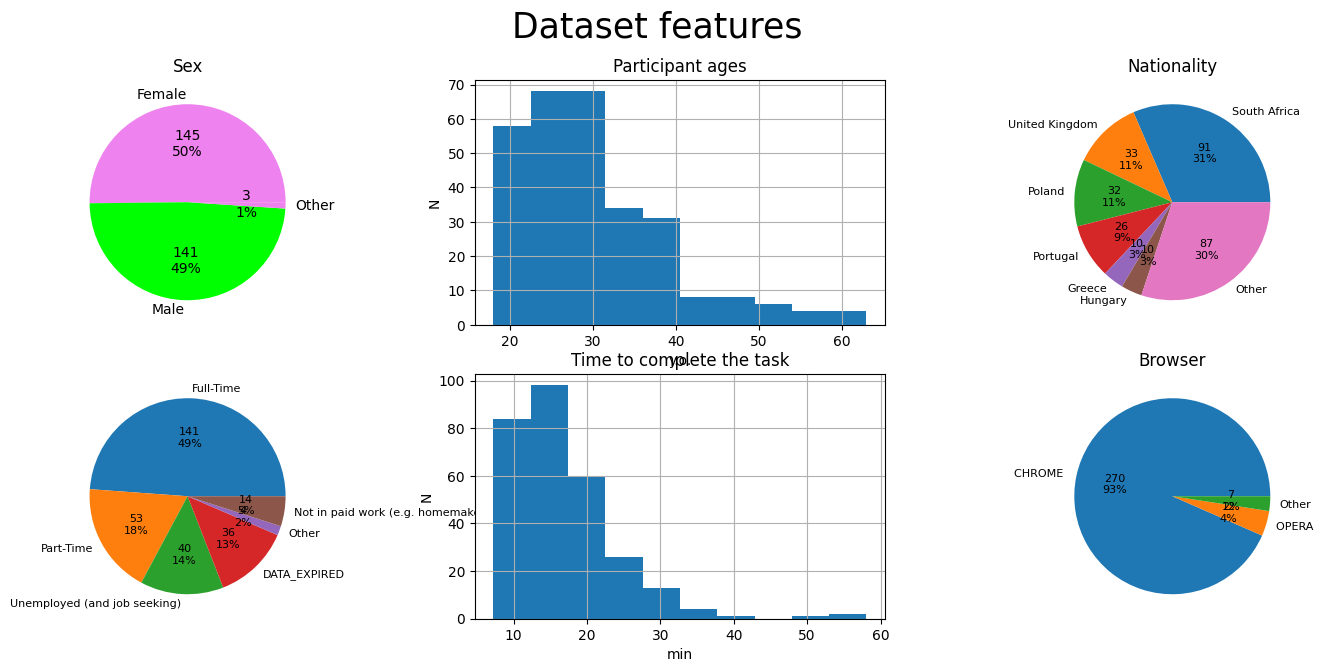

In [2]:
plot_this_dataframe = full_dataframe



fig, axs = plt.subplots(2, 3, dpi=100,figsize = (18,7))
fig.suptitle("Dataset features",fontsize=25)
ax_sex = axs[0,0]
ax_age = axs[0,1]
ax_country = axs[0,2]
ax_employment = axs[1,0]
ax_time_to_complete_task = axs[1,1]
ax_browser = axs[1,2]


ax_sex.set_title("Sex")
def label_function(val):
    return f'{val / 100 * len(plot_this_dataframe):.0f}\n{val:.0f}%'
plot_this_dataframe.groupby('Sex').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 10},
                                 colors=['violet', 'lime'], ax=ax_sex)

ax_age.set_title("Participant ages")
ax_age.hist(plot_this_dataframe["Age"],bins=10)
ax_age.set_xlabel("y.o.")
ax_age.set_ylabel("N")
ax_age.grid()    

ax_country.set_title("Nationality")
counts = plot_this_dataframe["Nationality"].value_counts()
# Define threshold for "Other" category
threshold = 10
# Group small categories into "Other"
counts_filtered = counts[counts >= threshold]  # Keep large categories
other_count = counts[counts < threshold].sum()  # Sum of small categories
# Add "Other" category if needed
if other_count > 0:
    counts_filtered["Other"] = other_count
counts_filtered.plot(kind='pie', autopct=label_function, textprops={'fontsize': 8}, ax=ax_country)
ax_country.set_ylabel('')

print(plot_this_dataframe["study_name"].value_counts())

counts = plot_this_dataframe["Employment status"].value_counts()
# Define threshold for "Other" category
threshold = 10
# Group small categories into "Other"
counts_filtered = counts[counts >= threshold]  # Keep large categories
other_count = counts[counts < threshold].sum()  # Sum of small categories
# Add "Other" category if needed
if other_count > 0:
    counts_filtered["Other"] = other_count
counts_filtered.plot(kind='pie', autopct=label_function, textprops={'fontsize': 8}, ax=ax_employment)
ax_employment.set_ylabel('')


ax_time_to_complete_task.set_title("Time to complete the task")
time_min = plot_this_dataframe["application_measured_timetaken"]/60
ax_time_to_complete_task.hist(time_min,bins=10)
ax_time_to_complete_task.set_xlabel("min")
ax_time_to_complete_task.set_ylabel("N")
ax_time_to_complete_task.grid()    

# print('Browser check : ')
# print(plot_this_dataframe["browser"])
ax_browser.set_title("Browser")
counts = plot_this_dataframe["browser"].value_counts()
# Define threshold for "Other" category
threshold = 10
# Group small categories into "Other"
counts_filtered = counts[counts >= threshold]  # Keep large categories
other_count = counts[counts < threshold].sum()  # Sum of small categories
# Add "Other" category if needed
if other_count > 0:
    counts_filtered["Other"] = other_count
counts_filtered.plot(kind='pie', autopct=label_function, textprops={'fontsize': 8}, ax=ax_browser)
ax_browser.set_ylabel('')


C:\Users\annic\AppData\Local\Temp\ipykernel_12628\3048505493.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = plot_this_dataframe.groupby('noise_category')['final_performance'].mean()
C:\Users\annic\AppData\Local\Temp\ipykernel_12628\3048505493.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(ax=axs[0],x="noise_category", y="final_performance",
C:\Users\annic\AppData\Local\Temp\ipykernel_12628\3048505493.py:8: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='area'` for the same effect.
  ax = sns.violinplot(ax=axs[0],x="noise_category", y="final_performance",
C:\Users\a

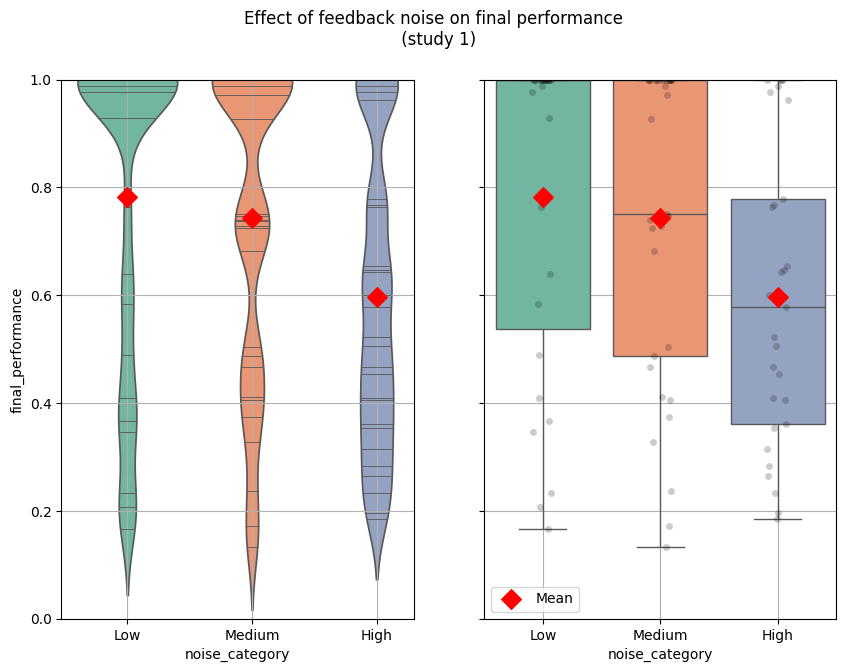

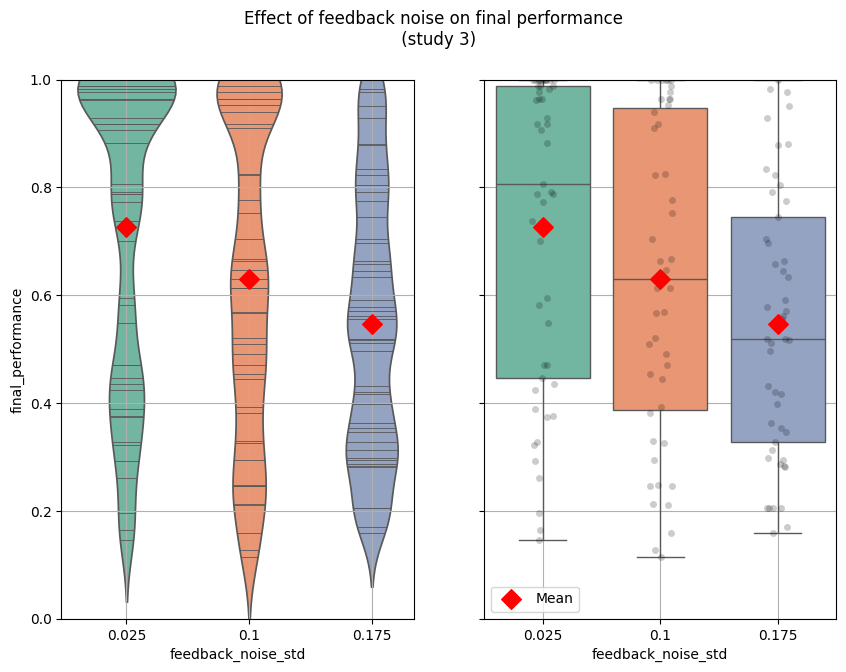

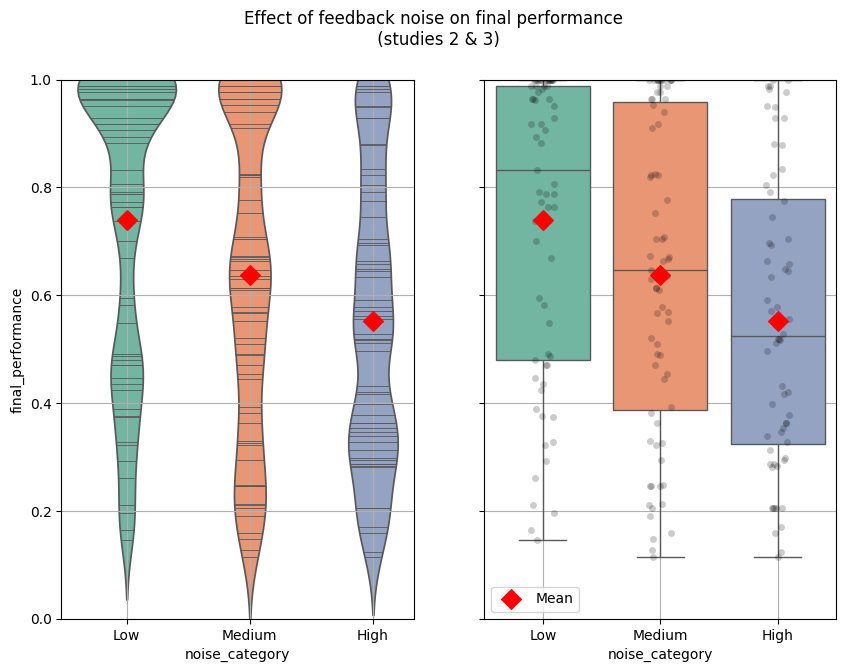

In [3]:
plot_this_dataframe = full_dataframe[full_dataframe["study_name"] == "study_1"]

means = plot_this_dataframe.groupby('noise_category')['final_performance'].mean()


fig,axs = plt.subplots(1,2,sharey=True,figsize = (10,7))
fig.suptitle("Effect of feedback noise on final performance \n (study 1)")
ax = sns.violinplot(ax=axs[0],x="noise_category", y="final_performance",
                    data=plot_this_dataframe, palette="Set2",
                    scale="area", inner="stick",
                    scale_hue=True, bw=.2)
ax.scatter(np.arange(len(means)), means, color='red', label='Mean', zorder=5, s=100, marker='D')

ax = sns.boxplot(ax=axs[1],x="noise_category", y="final_performance",
                    data=plot_this_dataframe, palette="Set2")

# Adjust zorder and label
ax.scatter(np.arange(len(means)), means, color='red', label='Mean', zorder=5, s=100, marker='D')
# Adding a legend to label the means
ax.legend()

# add stripplot to boxplot with Seaborn
sns.stripplot(ax = axs[1], y='final_performance', x='noise_category', 
                   data=plot_this_dataframe, 
                   jitter=True, 
                   marker='o', 
                   alpha=0.2,
                   color='black')

for ax in axs :
    ax.grid()
    ax.set_ylim([0,1])
    
# -------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------- 
# -------------------------------------------------------------------------------------------------------

plot_this_dataframe = full_dataframe[full_dataframe["study_name"] == "study_3"]

means = plot_this_dataframe.groupby('feedback_noise_std')['final_performance'].mean()
# print(subjects_df["performance"])


fig,axs = plt.subplots(1,2,sharey=True,figsize = (10,7))
fig.suptitle("Effect of feedback noise on final performance \n (study 3)")
ax = sns.violinplot(ax=axs[0],x="feedback_noise_std", y="final_performance",
                    data=plot_this_dataframe, palette="Set2",
                    scale="area", inner="stick",
                    scale_hue=True, bw=.2)
ax.scatter(np.arange(len(means)), means, color='red', label='Mean', zorder=5, s=100, marker='D')

ax = sns.boxplot(ax=axs[1],x="feedback_noise_std", y="final_performance",
                    data=plot_this_dataframe, palette="Set2")

# Adjust zorder and label
ax.scatter(np.arange(len(means)), means, color='red', label='Mean', zorder=5, s=100, marker='D')
# Adding a legend to label the means
ax.legend()

# add stripplot to boxplot with Seaborn
sns.stripplot(ax = axs[1], y='final_performance', x='feedback_noise_std', 
                   data=plot_this_dataframe, 
                   jitter=True, 
                   marker='o', 
                   alpha=0.2,
                   color='black')

for ax in axs :
    ax.grid()
    ax.set_ylim([0,1])


# -------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------- 
# -------------------------------------------------------------------------------------------------------

plot_this_dataframe = full_dataframe[(full_dataframe["study_name"] == "study_3" ) | (full_dataframe["study_name"] == "study_2")]

means = plot_this_dataframe.groupby('noise_category')['final_performance'].mean()


fig,axs = plt.subplots(1,2,sharey=True,figsize = (10,7))
fig.suptitle("Effect of feedback noise on final performance \n (studies 2 & 3)")
ax = sns.violinplot(ax=axs[0],x="noise_category", y="final_performance",
                    data=plot_this_dataframe, palette="Set2",
                    scale="area", inner="stick",
                    scale_hue=True, bw=.2)
ax.scatter(np.arange(len(means)), means, color='red', label='Mean', zorder=5, s=100, marker='D')

ax = sns.boxplot(ax=axs[1],x="noise_category", y="final_performance",
                    data=plot_this_dataframe, palette="Set2")

# Adjust zorder and label
ax.scatter(np.arange(len(means)), means, color='red', label='Mean', zorder=5, s=100, marker='D')
# Adding a legend to label the means
ax.legend()

# add stripplot to boxplot with Seaborn
sns.stripplot(ax = axs[1], y='final_performance', x='noise_category', 
                   data=plot_this_dataframe, 
                   jitter=True, 
                   marker='o', 
                   alpha=0.2,
                   color='black')

for ax in axs :
    ax.grid()
    ax.set_ylim([0,1])

Next !

<function matplotlib.pyplot.show(close=None, block=None)>

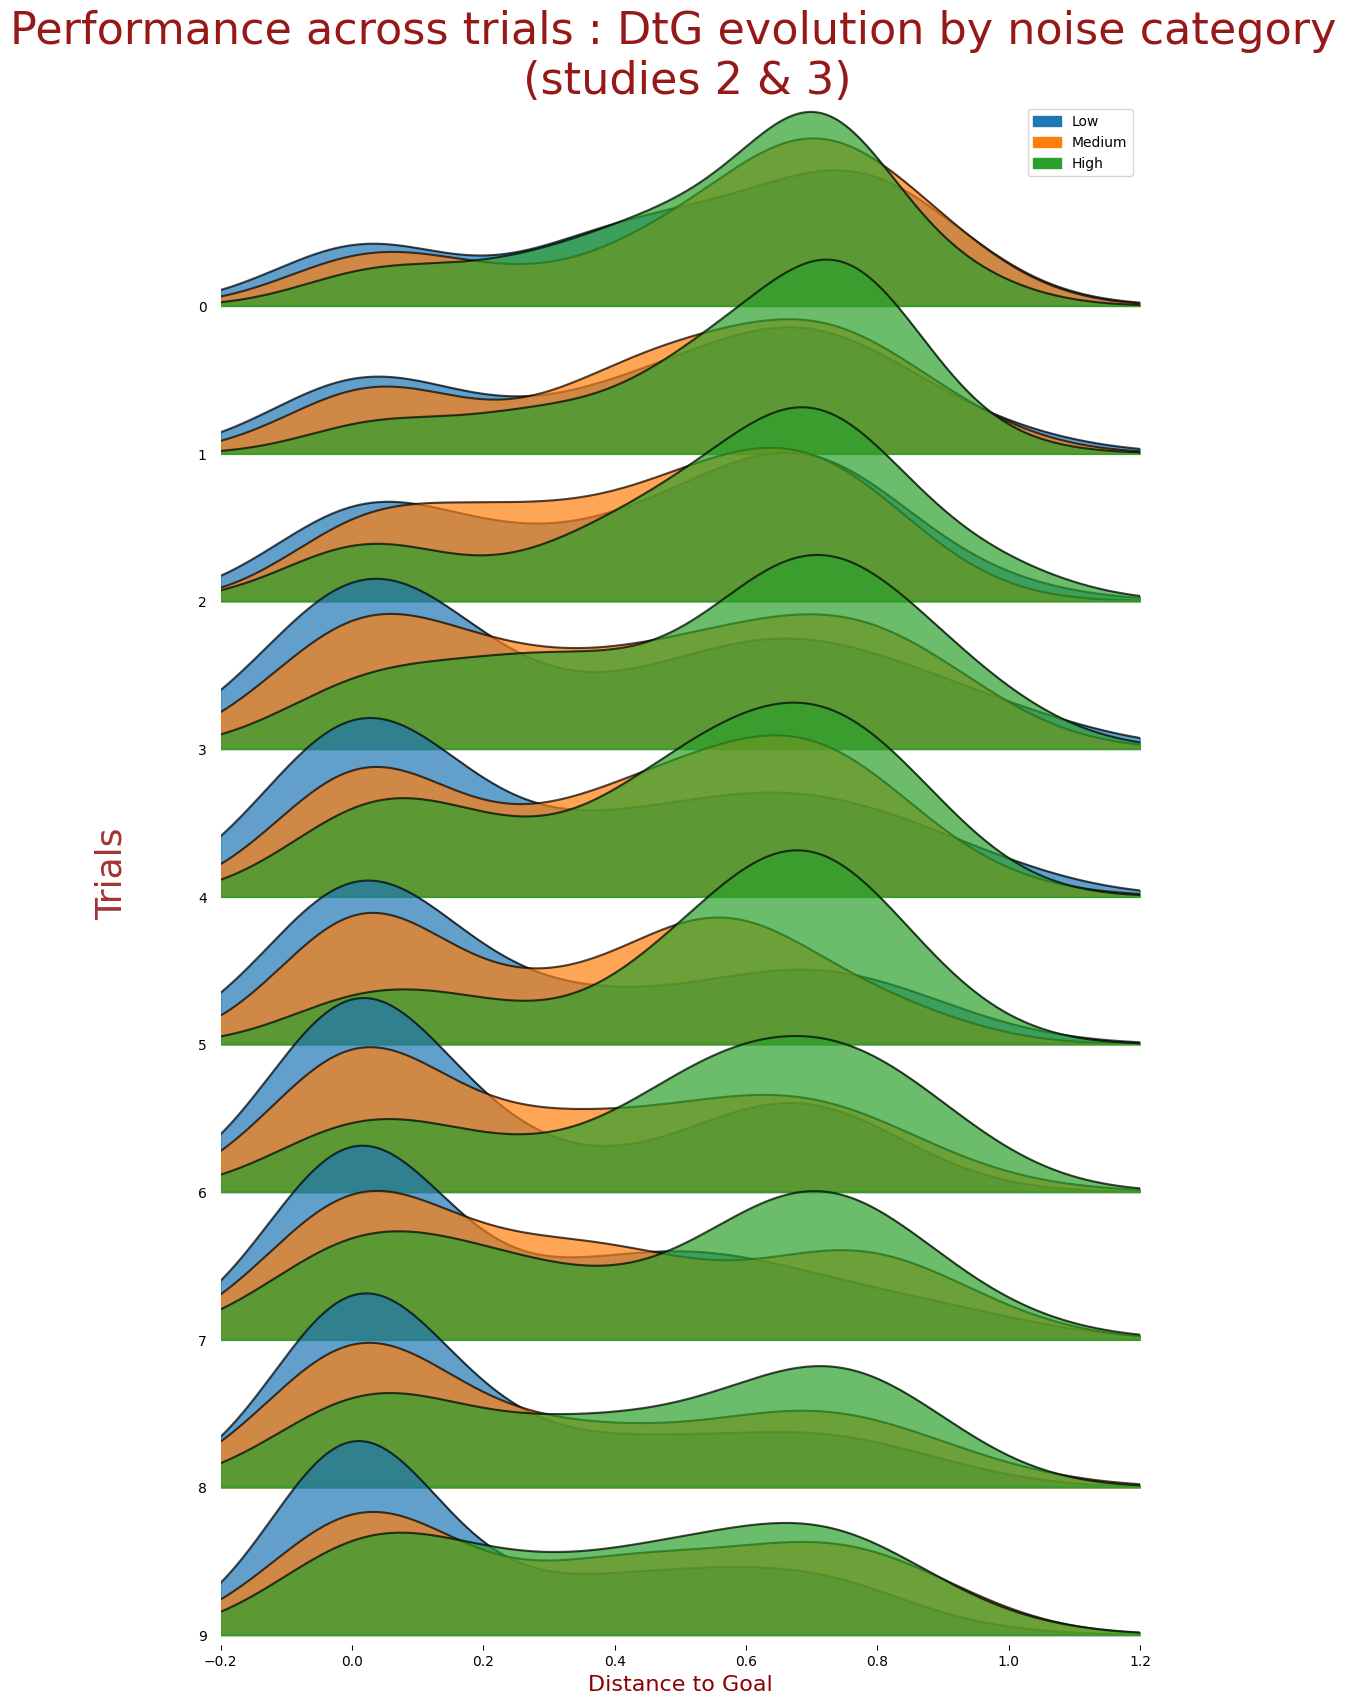

In [4]:
plot_this_dataframe = full_dataframe[(full_dataframe["study_name"] == "study_3" ) | (full_dataframe["study_name"] == "study_2")]


# Final plot : only look at the last tfin timesteps 
import joypy

eps = 0.2
tfin = 2

# Calculate the mean and std of the feedabck and (1- euclidian distance) arrays for each group
all_distances = np.stack(plot_this_dataframe['norm_distance_to_goal'])[:,:-1,:]
Nsubjs = plot_this_dataframe.shape[0]

# Only look at the last timesteps avg : 
all_distances = np.mean(all_distances[:,:,-tfin:],axis=-1)
Nsteps = all_distances.shape[-1]

all_subject_indexes = np.repeat(np.expand_dims(np.arange(Nsubjs),1),Nsteps,1)
all_trials_indexes = np.repeat(np.expand_dims(np.arange(Nsteps),0),Nsubjs,0)
all_subject_noise_cat = np.repeat(np.expand_dims(np.array(plot_this_dataframe['noise_category']),1),Nsteps,1)
all_noises = np.repeat(np.expand_dims(np.array(plot_this_dataframe['feedback_noise_std']),1),Nsteps,1)

# Dataframe : columns : step x subject_id x noise_level x final_feedback x final_distance
new_df = pd.DataFrame()
new_df["trial"] = list(all_trials_indexes.flatten())
new_df["subject"] = list(all_subject_indexes.flatten())
new_df["final_distance"] = list(all_distances.flatten())
new_df["noise"] = list(all_noises.flatten())
new_df['noise_cat'] = list(all_subject_noise_cat.flatten())


BB = new_df.pivot_table(index=['subject','trial'], columns='noise_cat', values='final_distance').reset_index()

fig, axs = joypy.joyplot(BB, column=["Low", "Medium", "High"], by="trial", ylim='own', figsize=(10,16) ,alpha=0.7, legend=True)
# Decoration
plt.title('Performance across trials : DtG evolution by noise category \n (studies 2 & 3)', fontsize=32, color='darkred', alpha=0.9)
plt.rc("font", size=20)
plt.xlabel('Distance to Goal',  fontsize=16, color='darkred', alpha=1)
plt.ylabel('Trial', fontsize=26,  color='darkred', alpha=0.8)
ax = axs[-1]
ax.yaxis.set_label_coords(-0.1, .5)
ax.set_ylabel("Trials")
ax.yaxis.set_visible(True)
ax.yaxis.set_ticks([])
plt.show

Look at the cross category bar plot !

C:\Users\annic\AppData\Local\Temp\ipykernel_12628\478353189.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_per_group = counts.groupby("noise_category")["counts"].transform("sum")
C:\Users\annic\AppData\Local\Temp\ipykernel_12628\478353189.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


0    65
1    71
2    64
3    71
4    64
5    64
6    71
7    65
8    65
Name: counts, dtype: int64
CategoricalIndex(['Medium', 'Low', 'High'], categories=['Low', 'Medium', 'High'], ordered=True, dtype='category', name='noise_category')
71
65
64


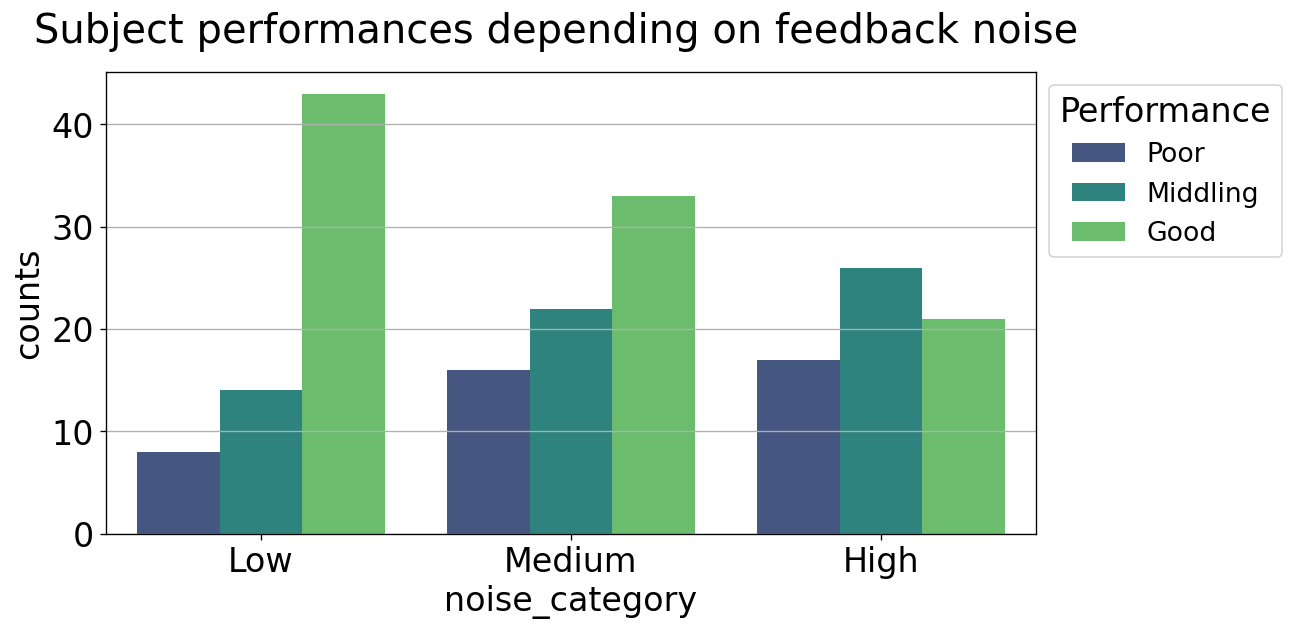

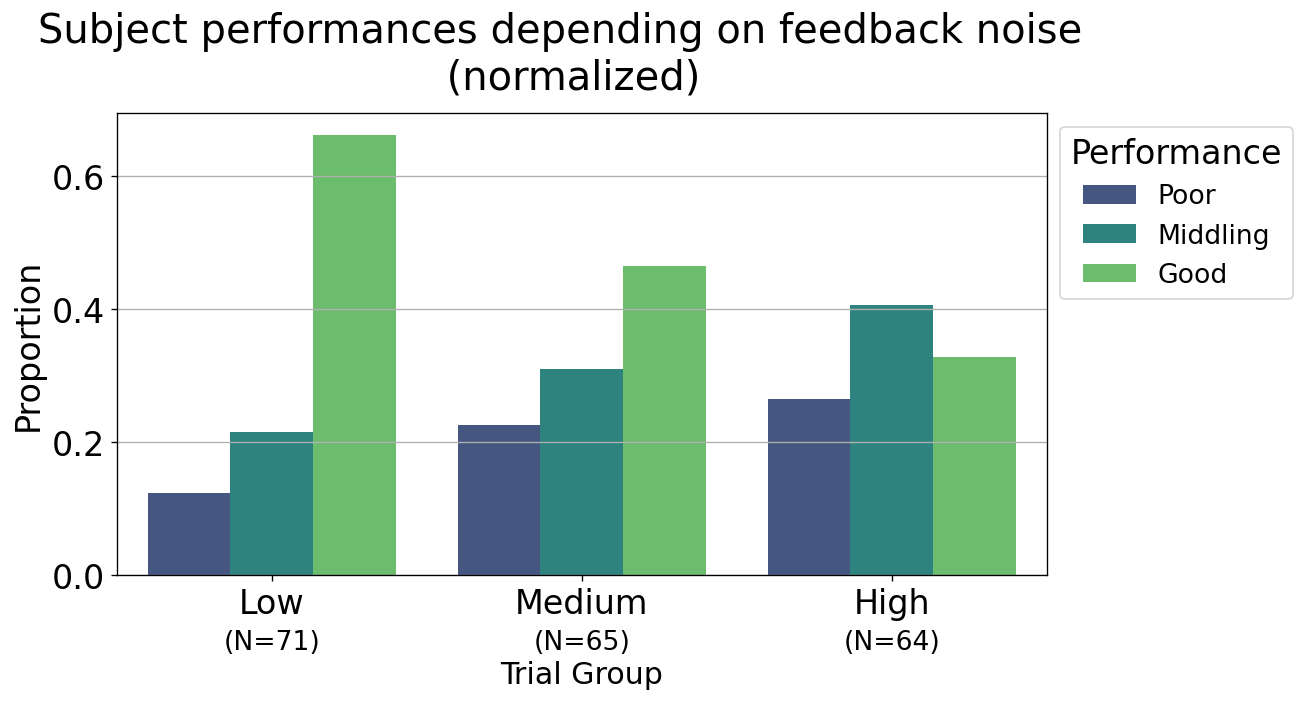

In [5]:
plot_this_dataframe = full_dataframe[(full_dataframe["study_name"] == "study_3" ) | (full_dataframe["study_name"] == "study_2")]
# plot_this_dataframe = full_dataframe[(full_dataframe["study_name"] == "study_1" )]

reduced_df = plot_this_dataframe[["noise_category","performance_category"]]

# Count the occurrences of each combination
counts = reduced_df.value_counts().reset_index()
counts.columns = ["noise_category", "performance_category", "counts"]
# Compute the total number of subjects per Trial Group
total_per_group = counts.groupby("noise_category")["counts"].transform("sum")
print(total_per_group)
# Normalize counts (convert to proportion)
counts["Proportion"] = counts["counts"] / total_per_group


# Plot the grouped bar chart
fig,ax = plt.subplots(figsize=(10,5),dpi=120)
fig.suptitle("Subject performances depending on feedback noise")
ax.grid()
sns.barplot(ax=ax,data=counts, x="noise_category", y="counts", hue="performance_category", palette="viridis")
plt.legend(title="Performance", fontsize=16, loc="upper left", bbox_to_anchor=(1, 1))
fig.show()


fig,ax = plt.subplots(figsize=(10,5),dpi=120)
fig.suptitle("Subject performances depending on feedback noise \n (normalized)",y=1.05)
ax.grid()
sns.barplot(ax=ax,data=counts, x="noise_category", y="Proportion", hue="performance_category", palette="viridis")
plt.legend(title="Performance", fontsize=16, loc="upper left", bbox_to_anchor=(1, 1))
plt.xlabel("Trial Group", fontsize=18, labelpad=24)  # labelpad controls vertical position

# Annotate bars with total subject counts per Trial Group
total_noise_params = plot_this_dataframe["noise_category"].value_counts()
print(total_noise_params.index)
for i, nc in enumerate(total_noise_params.index):
    total = total_noise_params[nc]
    print(total)
    ax.text(i, -0.12, f"(N={total})", ha="center", va="bottom", fontsize=16)
    


Todo here : more plots of performance evolution across trials ? 

Let's plot some actions ! 

[0, 1, 2, 3, 4, 5, 6, 7]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


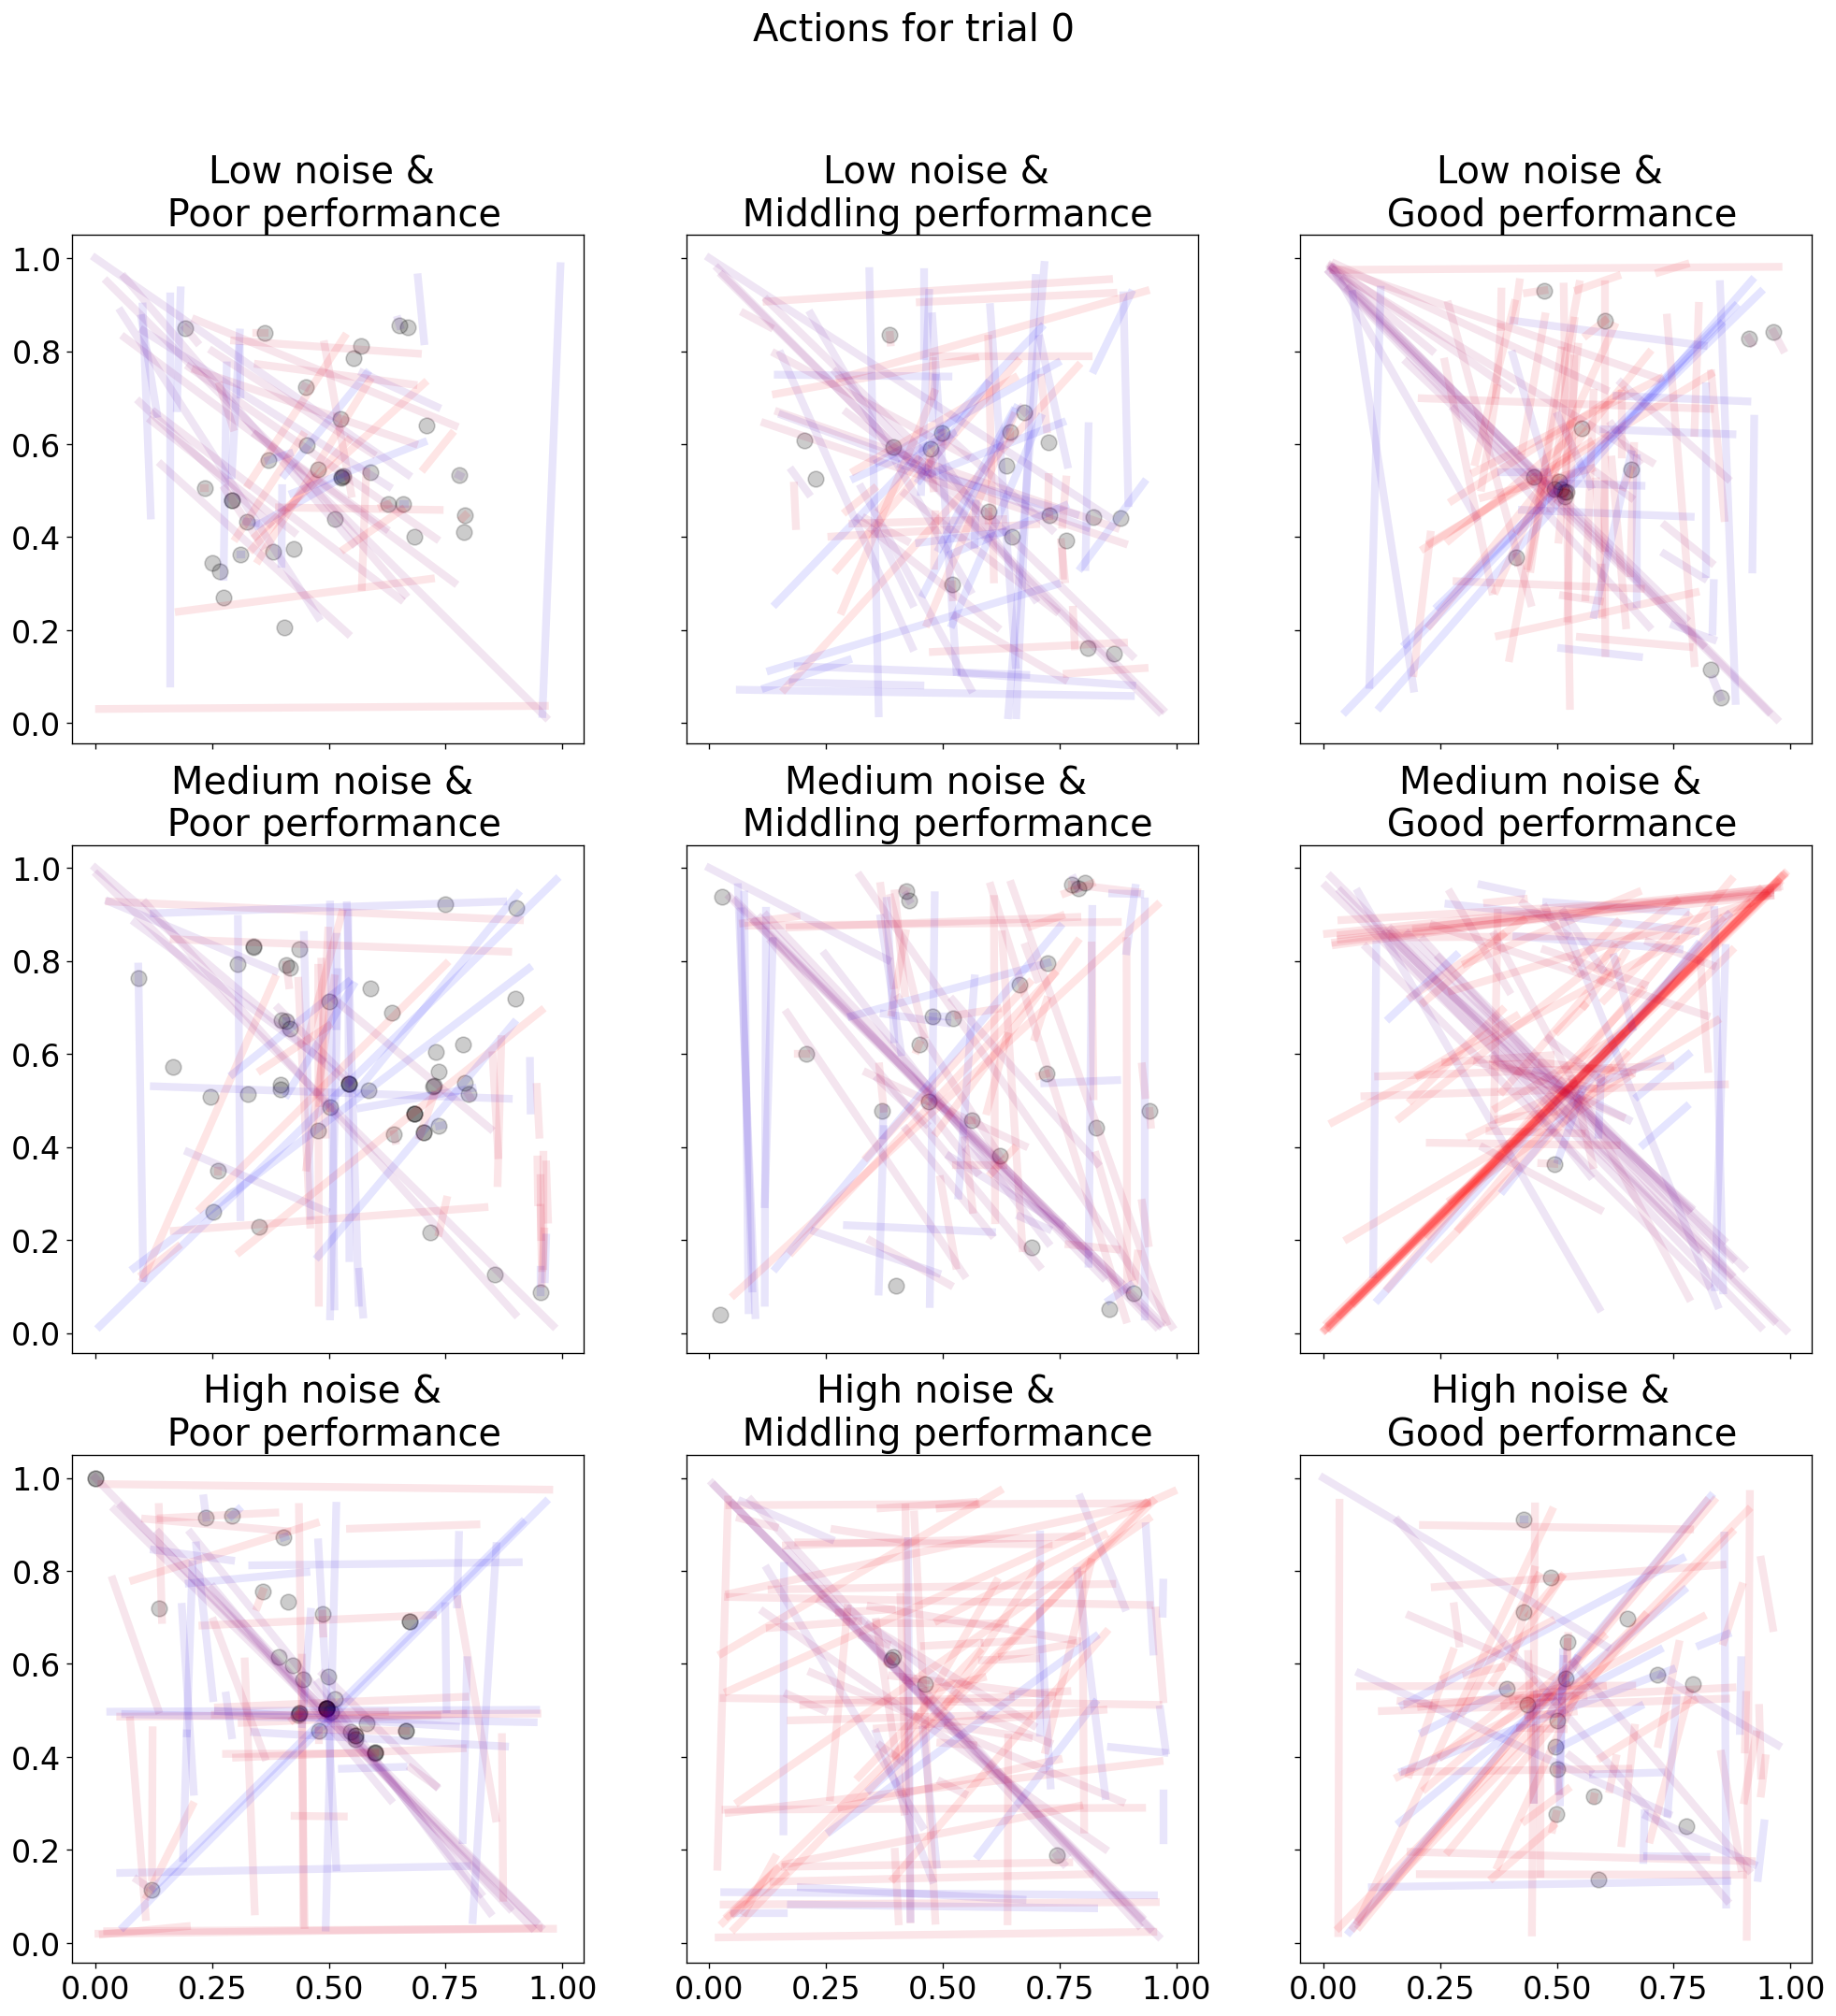

In [6]:
plot_this_dataframe = full_dataframe[(full_dataframe["study_name"] == "study_3" ) | (full_dataframe["study_name"] == "study_2")]

import random

def random_selection(subjects, num_to_select):
    # Ensure we don't request more selections than available subjects
    if num_to_select >= len(subjects):
        return subjects
    # Randomly select 'num_to_select' items without repetition
    return random.sample(subjects, num_to_select)


def cosine_similarity(a, b):
    cos_simimarity =  (np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)+0.00001))
    return (cos_simimarity + 1)/2

fig,axs = plt.subplots(3,3,dpi=120,sharex=True,sharey=True,figsize=(20,20))
trial_list  = [0]
ender = "s" if len(trial_list) > 1 else ""
fig.suptitle("Actions for trial{} {}".format(ender,"&".join([str(t) for t in trial_list])))


max_plot_subjs = 10
for i ,noise_category in enumerate(["Low","Medium","High"]):
    for j, performance_category in enumerate(["Poor","Middling","Good"]):
        ax = axs[i,j]
        ax.set_title("{} noise & \n {} performance".format(noise_category,performance_category))
        # print(noise_category)
        
        reduced_dataframe = plot_this_dataframe[(plot_this_dataframe["noise_category"]==noise_category) & (plot_this_dataframe["performance_category"]==performance_category)]
        
        
        points = np.stack(reduced_dataframe["raw_points"])[...,:2]
        
        n_subj,n_trials,n_actions,n_points,n_coords = points.shape
        
        
        # Let's pick a random amount of subjects (up to max_plot_subjs):
        all_subjs = list(range(n_subj))
        print(all_subjs)
        
        
        for subj in random_selection(all_subjs,max_plot_subjs):
            
            # for trial in range(n_trials):
                
            for trial in trial_list:
                for action in range(n_actions):
                                                    
                    one_action = points[subj,trial,action,:,:]
                    
                    
                    t = cosine_similarity(one_action[1] - one_action[0],np.array([100,100]))
                    col = np.array([1,0,0])*t + (1-t)*np.array([0,0,1])
                    
                    ax.plot(one_action[:,0], one_action[:,1],'-', lw=5,alpha=0.1,color=col)
                    
                    
                    if (np.linalg.norm(one_action[1] - one_action[0])<0.05): 
                        
                        ax.scatter(one_action[1,0],one_action[1,1],s=100,alpha=0.2,color="black")                    


# # plot_this_dataframe = full_dataframe[(full_dataframe["study_name"] == "study_1" )]
# fig,axs = plt.subplots(3,3,dpi=120,sharex=True,sharey=True,figsize=(20,20))

# for i ,noise_category in enumerate(["Low","Medium","High"]):
#     for j, performance_category in enumerate(["Poor","Middling","Good"]):
#         ax = axs[i,j]
#         ax.set_title("{} noise & {} performance".format(noise_category,performance_category))
#         # print(noise_category)
        
#         reduced_dataframe = plot_this_dataframe[(plot_this_dataframe["noise_category"]==noise_category) & (plot_this_dataframe["performance_category"]==performance_category)]
        
        
#         points = np.stack(reduced_dataframe["raw_points"])[...,:2]
        
#         n_subj,n_trials,n_actions,n_points,n_coords = points.shape
#         for subj in range(n_subj):
            
#             # for trial in range(n_trials):
                
#             for trial in [5]:
#                 for action in range(n_actions):
#                     one_action = points[subj,trial,action,:,:]
                    
                    
#                     t = cosine_similarity(one_action[1] - one_action[0],np.array([100,100]))
#                     col = np.array([1,0,0])*t + (1-t)*np.array([0,0,1])
                    
#                     ax.plot(one_action[:,0], one_action[:,1],'-', lw=5,alpha=0.1,color=col)
                    
                    
#                     if (np.linalg.norm(one_action[1] - one_action[0])<0.05): 
                        
#                         ax.scatter(one_action[1,0],one_action[1,1],s=100,alpha=0.2,color="black")
        

# fig.tight_layout()

In [7]:
import matplotlib.animation as animation


if not(os.path.exists("animated_lines.gif")):

    def cosine_similarity(a, b):
        cos_simimarity =  (np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)+0.00001))
        return (cos_simimarity + 1)/2

    plot_this_dataframe = full_dataframe[(full_dataframe["study_name"] == "study_3" ) | (full_dataframe["study_name"] == "study_2")]
    # plot_this_dataframe = full_dataframe[(full_dataframe["study_name"] == "study_1" )]


    list_of_data,lines,points = [],[],[]
    for i ,noise_category in enumerate(["Low","Medium","High"]):
        list_of_data.append([])
        
        lines.append([])
        points.append([])
        for j, performance_category in enumerate(["Poor","Middling","Good"]):
            ax = axs[i,j]
            ax.set_title("{} noise & {} performance".format(noise_category,performance_category))
            
            reduced_dataframe = plot_this_dataframe[(plot_this_dataframe["noise_category"]==noise_category) & (plot_this_dataframe["performance_category"]==performance_category)]
            
            
            two_points = np.stack(reduced_dataframe["raw_points"])[...,:2]
            n_subj,n_trials,n_actions,n_points,n_coords = two_points.shape
            
            list_of_data[-1].append(np.reshape(two_points,(n_subj,-1,2,2)))
            lines[-1].append([[]])
            points[-1].append([[]])


    fig,axs = plt.subplots(3,3,dpi=120,sharex=True,sharey=True,figsize=(20,20))

    def init():
        fig.suptitle("Frame {}".format(0))
        for i ,noise_category in enumerate(["Low","Medium","High"]):
            for j, performance_category in enumerate(["Poor","Middling","Good"]):
                ax = axs[i,j]
                ax.set_title("{} noise & {} performance".format(noise_category,performance_category))

    # Update function
    def update(frame):
        print(frame)
        
        global lines
        global points
        
        # Remove old lines
        for _line in lines:
            for l in _line :
                for l0 in l:
                    try :
                        l0.remove()
                    except:
                        print("Sure bruh")
                l.clear()
        for _point in points:
            for p in _point:
                for p0 in p: 
                    try : 
                        p0.remove()
                    except: 
                        print("Sure sir")
                p.clear()
        
        for i ,noise_category in enumerate(["Low","Medium","High"]):
            for j, performance_category in enumerate(["Poor","Middling","Good"]):
                ax = axs[i,j]
                
                n_subj = list_of_data[i][j].shape[0]
                for subj in range(n_subj):
                    
                    
                    for slider in [-4,-3,-2,-1,0]:
                        if (frame + slider >= 0) and (frame+slider < list_of_data[i][j].shape[1]):
                            one_action = list_of_data[i][j][subj,frame+slider,:,:]

                            t = cosine_similarity(one_action[1] - one_action[0],np.array([100,100]))
                            col = np.array([1,0,0])*t + (1-t)*np.array([0,0,1])
                            
                            max_alpha = 0.2
                            slider_alpha = max_alpha/np.pow(1.0+np.abs(slider),1.2)
                            l, = ax.plot(one_action[:,0], one_action[:,1],'-', lw=5,alpha=slider_alpha,color=col)
                            
                            lines[i][j].append(l)  
                            
                            if (np.linalg.norm(one_action[1] - one_action[0])<0.05): 
                                print(one_action)
                                p = ax.scatter(one_action[1,0],one_action[1,1],s=100,alpha=slider_alpha,color="black")
                                points[i][j].append(p)
                    
        fig.suptitle("Frame {}".format(frame))
        return lines+points
    
    
    ani = animation.FuncAnimation(fig, update, frames=110, init_func=init, interval=100, blit=False)
    ani.save("animated_lines.gif", writer="pillow", fps=10)


Can we predict ultimate performances given initial trials ? 

Let's look at the average initial actions in all 3 performance classes. Do they predict good performers ? Does it depend on noise level of the feedback ?

    final_performance noise_category  \
89           0.338832           High   
90           0.950000           High   
91           0.929289           High   
92           0.988215           High   
93           0.378514           High   

                                   action_barycenters  
89  [[0.16999999999999998, 0.6226666666666667], [0...  
90  [[0.506, 0.44933333333333336], [0.654666666666...  
91  [[0.33666666666666667, 0.6386666666666666], [0...  
92  [[0.458, 0.4786666666666667], [0.4860000000000...  
93  [[0.4733333333333334, 0.504], [0.4666666666666...  
[False False False ... False False False]
(2000, 4)
    final_performance noise_category  \
89           0.338832           High   
90           0.950000           High   
91           0.929289           High   
92           0.988215           High   
93           0.378514           High   

                                     action_distances  
89  [0.18699494942674555, 0.6511528238439882, 0.12...  
90  [0.47361118605

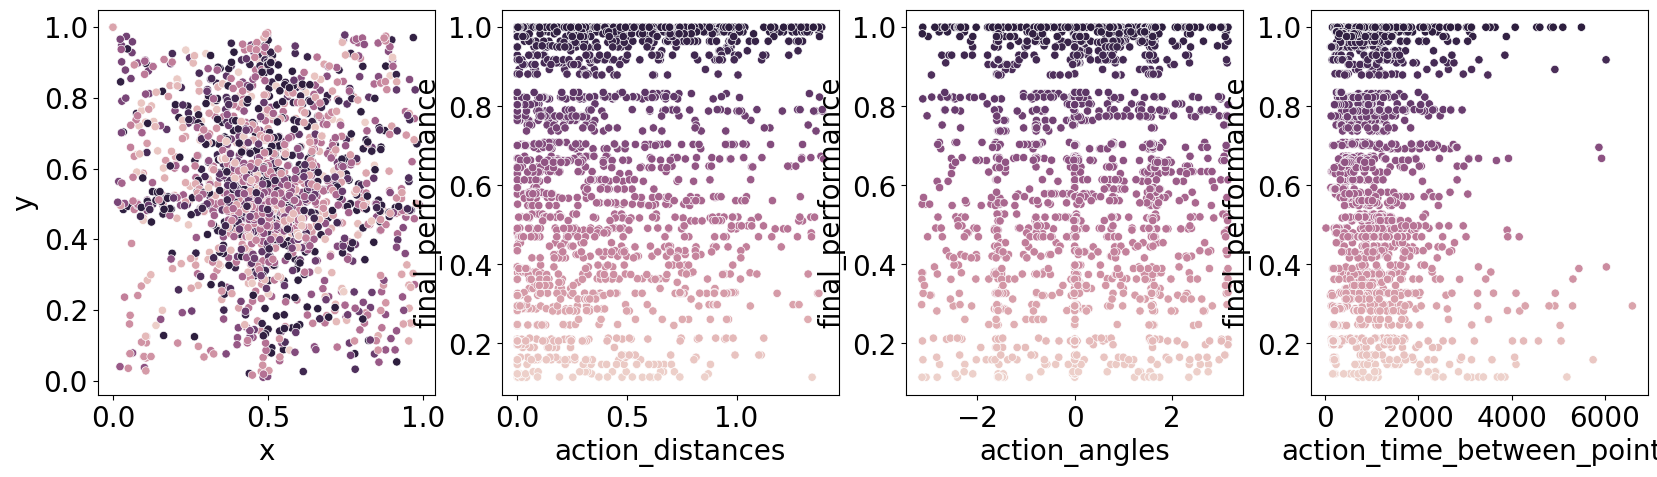

In [8]:
plot_this_dataframe = full_dataframe[(full_dataframe["study_name"] == "study_3" ) | (full_dataframe["study_name"] == "study_2")]


potential_predictors = ["action_barycenters","action_distances","action_angles","action_time_between_points"]

first_T_trials = 1
first_t_actions = 10

fig,axs = plt.subplots(1,len(potential_predictors),figsize=(5*len(potential_predictors),5))

for k,predictor in enumerate(potential_predictors) :
    ax = axs[k]
    # reduced_dataframe = plot_this_dataframe[[predictor,"final_performance"]]
    
    all_actions = [np.array(a)[:first_T_trials,:first_t_actions].squeeze() for a in plot_this_dataframe[predictor]]
    
    reduced_df = plot_this_dataframe[["final_performance","noise_category"]].copy()
    reduced_df[predictor] = list(all_actions)
    
    print(reduced_df.head())
    
    exploded_df = reduced_df.explode(predictor).reset_index()
    print(exploded_df.index.duplicated())
    print(exploded_df.shape)
    
    if predictor=="action_barycenters" : 
        exploded_df['x'] = exploded_df[predictor].apply(lambda x: x[0])
        exploded_df['y'] = exploded_df[predictor].apply(lambda x: x[1])
        sns.scatterplot(ax=ax,data=exploded_df, x='x', y='y',hue='final_performance')
    else:
        sns.scatterplot(ax=ax,data=exploded_df, x=predictor, y='final_performance',hue='final_performance')
    ax.legend_.remove()

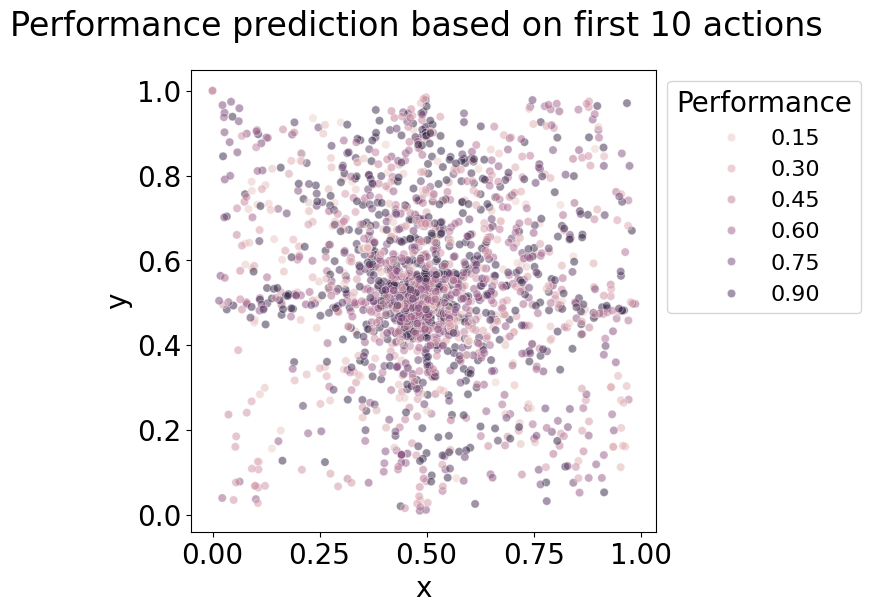

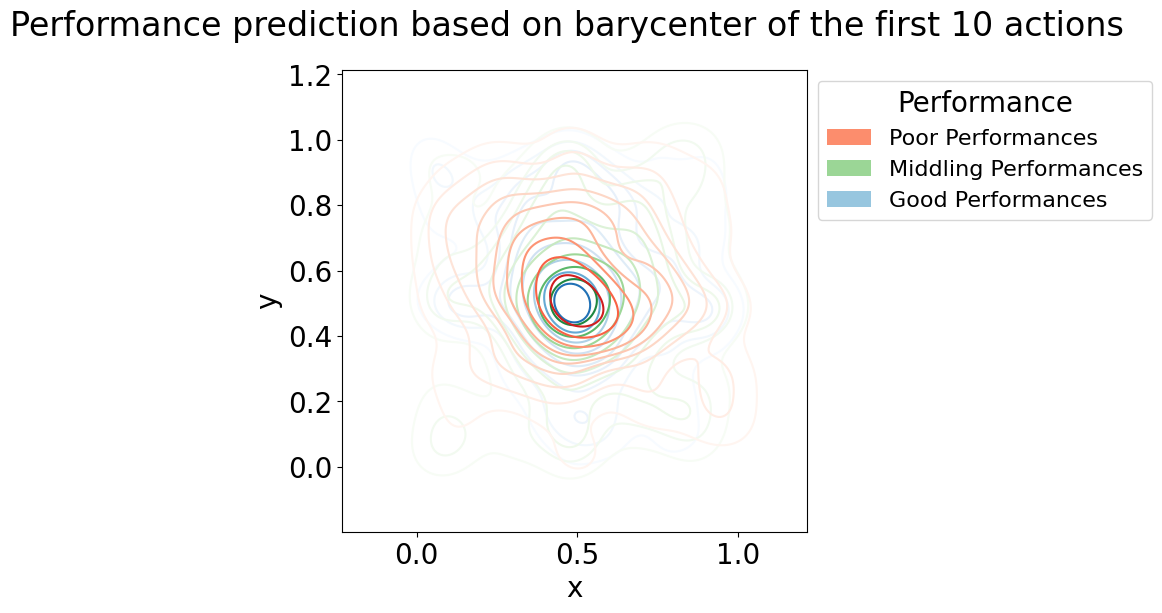

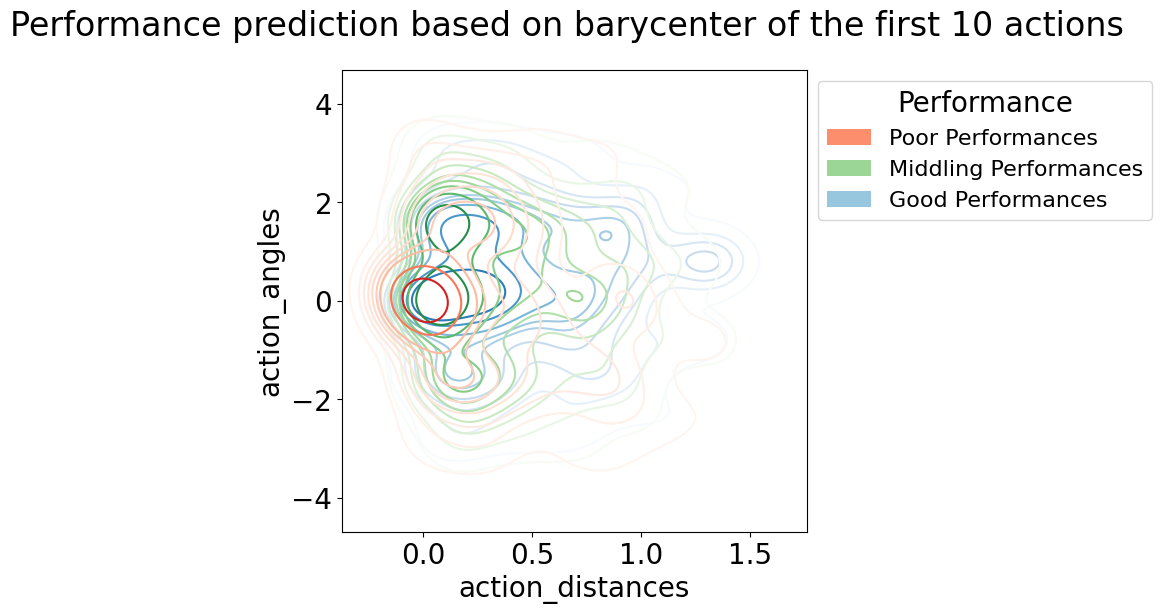

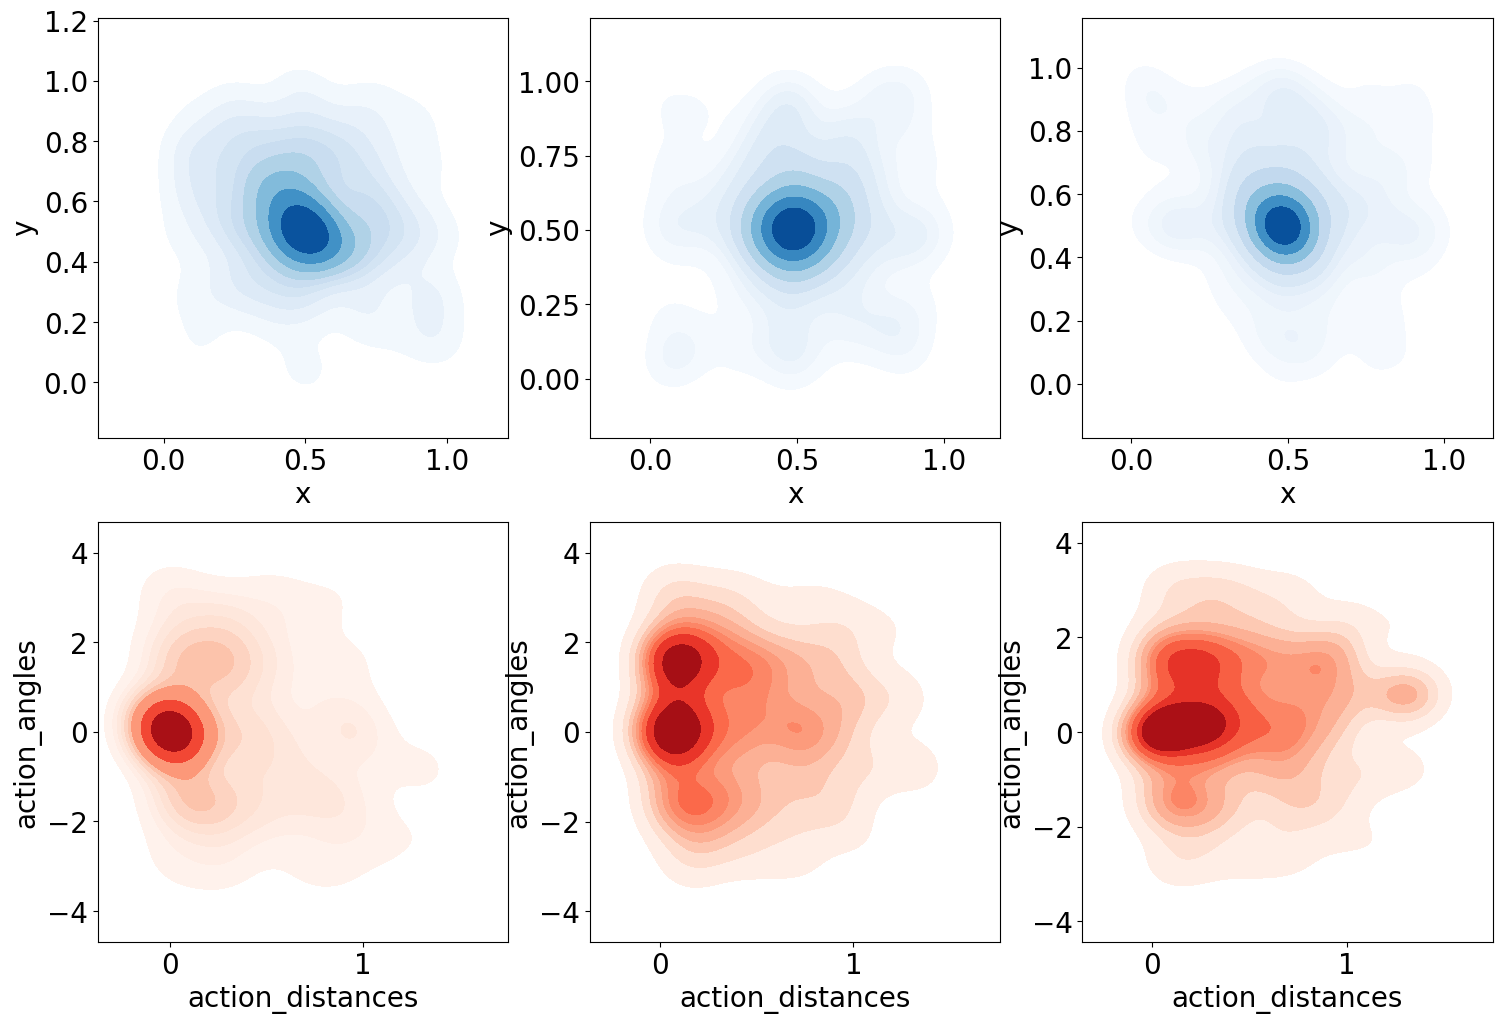

In [9]:
plot_this_dataframe = full_dataframe[(full_dataframe["study_name"] == "study_3" ) | (full_dataframe["study_name"] == "study_2")]


potential_predictors = ["action_barycenters","action_distances","action_angles","action_time_between_points"]

first_T_trials = 1
first_t_actions = 10

reduced_df = plot_this_dataframe[["final_performance","noise_category","performance_category"]].copy()
for predictor in potential_predictors:
    all_actions = [np.array(a)[:first_T_trials,:first_t_actions].squeeze() for a in plot_this_dataframe[predictor]]
    reduced_df[predictor] = list(all_actions)
df_exploded = reduced_df.explode(potential_predictors).reset_index(drop=True)

df_exploded['x'] = df_exploded["action_barycenters"].apply(lambda x: x[0])
df_exploded['y'] = df_exploded["action_barycenters"].apply(lambda x: x[1])


fig,ax=plt.subplots(figsize=(6,6))
fig.suptitle("Performance prediction based on first {} actions".format(first_t_actions*first_T_trials))
sns.scatterplot(ax=ax,data=df_exploded, x="x", y='y',hue='final_performance',alpha=0.5)
plt.legend(title="Performance", fontsize=16, loc="upper left", bbox_to_anchor=(1, 1))
plt.show()

fig,ax=plt.subplots(figsize=(6,6))
fig.suptitle("Performance prediction based on barycenter of the first {} actions".format(first_t_actions*first_T_trials))
sns.kdeplot(ax=ax,data=df_exploded[df_exploded['performance_category'] == 'Good'], x='x', y='y', cmap='Blues', fill=False ,label='Good Performances')
sns.kdeplot(ax=ax,data=df_exploded[df_exploded['performance_category'] == 'Middling'], x='x', y='y', cmap='Greens', fill=False, label='Middling Performances')
sns.kdeplot(ax=ax,data=df_exploded[df_exploded['performance_category'] == 'Poor'], x='x', y='y', cmap='Reds', fill=False, label='Poor Performances')
import matplotlib.patches as  mpatches
handles = [mpatches.Patch(facecolor=plt.cm.Reds(100), label="Poor Performances"),
           mpatches.Patch(facecolor=plt.cm.Greens(100), label="Middling Performances"),
           mpatches.Patch(facecolor=plt.cm.Blues(100), label="Good Performances")]
ax.legend(handles=handles,title="Performance", fontsize=16, loc="upper left", bbox_to_anchor=(1, 1))
plt.show()
plt.show()

fig,ax=plt.subplots(figsize=(6,6))
fig.suptitle("Performance prediction based on barycenter of the first {} actions".format(first_t_actions*first_T_trials))
sns.kdeplot(ax=ax,data=df_exploded[df_exploded['performance_category'] == 'Good'], x='action_distances', y='action_angles', cmap='Blues', fill=False ,label='Good Performances')
sns.kdeplot(ax=ax,data=df_exploded[df_exploded['performance_category'] == 'Middling'], x='action_distances', y='action_angles', cmap='Greens', fill=False, label='Middling Performances')
sns.kdeplot(ax=ax,data=df_exploded[df_exploded['performance_category'] == 'Poor'], x='action_distances', y='action_angles', cmap='Reds', fill=False, label='Poor Performances')
import matplotlib.patches as  mpatches
handles = [mpatches.Patch(facecolor=plt.cm.Reds(100), label="Poor Performances"),
           mpatches.Patch(facecolor=plt.cm.Greens(100), label="Middling Performances"),
           mpatches.Patch(facecolor=plt.cm.Blues(100), label="Good Performances")]
ax.legend(handles=handles,title="Performance", fontsize=16, loc="upper left", bbox_to_anchor=(1, 1))
plt.show()

fig,axs=plt.subplots(2,3,figsize=(18,12))
for k,performance_category in enumerate(["Poor","Middling","Good"]) :
    sns.kdeplot(ax = axs[0,k],data=df_exploded[df_exploded['performance_category'] == performance_category], x="x", y="y", cmap='Blues', fill=True)
for k,performance_category in enumerate(["Poor","Middling","Good"]) :
    sns.kdeplot(ax = axs[1,k],data=df_exploded[df_exploded['performance_category'] == performance_category], x="action_distances", y="action_angles", cmap='Reds', fill=True)
plt.show()

In [10]:
plot_this_dataframe = full_dataframe[(full_dataframe["study_name"] == "study_3" ) | (full_dataframe["study_name"] == "study_2")]


potential_predictors = ["action_barycenters","action_distances","action_angles","action_time_between_points"]

first_T_trials = 1
first_t_actions = 10


print(np.max(full_dataframe["final_performance"]))
print(np.max(full_dataframe["blind_trial_performance"]))

1.0
1.0
